**Have you ever sat in front of your TV and spent hours trying to decide what to watch?**
<img src="https://mlvillage.blob.core.windows.net/unsupervised/confused.jpeg" alt="confused" width="200" align="right" style="display:inline-block;"/>

**Do you ever wonder how companies like Netflix, Amazon etc. know exactly what to recommend to you?**

If yes, then you're in the right place. In this lab, we will introduce some basic recommendation techniques. By the time you finish, you should be able to create your own recommendation system!!

### Authors of this lab
**Super volunteer**: Priyank Mathur (prmathur@adobe.com) <br>
**Awesome volunteers**: Ankit Aggarwal (aagarwa@adobe.com), Megha Rawat (mrawat@adobe.com), Pulkit Gera (pugera@adobe.com), Rahul Mittal (rahmitta@adobe.com), Sudheer Sana (sudheer@adobe.com), Tarun Vashisth (vashisth@adobe.com) 

# Welcome to the level 1 lab for unsupervised machine learning. 

**Unsupervised learning** is the branch of machine learning that learns from data that has not been labeled, classified or categorized. While we build our recommendation system, we will take a high level tour of some of the techniques that can be employed when you are working with untagged data.

### We will cover the following topics -
* Importing and basic data manipulation
* Exploratory analysis and visualization
* Distance metrics
* Clustering
* Dimensionality reduction

We will be using the following special purpose python libraries that are useful for data science -
* [pandas](https://pandas.pydata.org/) - provides performant and easy-to-use data structures & analysis tools
* [numpy](http://www.numpy.org/) - the fundamental package for working with arrays and matrices
* [matplotlib](https://matplotlib.org/) - provides 2D plotting capability
   * [mplot3d](https://matplotlib.org/mpl_toolkits/mplot3d/index.html) - adds 3D plotting capability
   * [seaborn](https://seaborn.pydata.org/) - provides a high-level interface for drawing attractive and informative statistical graphics
* [scikit-learn](https://scikit-learn.org) - tools for machine learning, data mining and data analysis

In [1]:
import sys
sys.path.insert(0, '/home/asruser/unsupervised-learning-lab/')

# import necessary libraries, after executing this cell
# you can click the button below to see
# details on what was imported
from utils.imports import *
from utils import widget_utils

sns.set(style='whitegrid')

# Give option to show what was imported
widget_utils.show_imports()

Button(description='Show/hide what we imported', layout=Layout(width='20%'), style=ButtonStyle())

Output()

# Working with data

## Load data
The dataset has been obtained from https://grouplens.org/datasets/movielens/.

<cite>F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (2015).</cite> https://doi.org/10.1145/2827872

The Pandas library provides a very handy function called [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) to load the data into dataframes.

In [2]:
data_root = 'C:\\Users\mrawat'

# load data
movies_df = pd.read_csv(os.path.join(data_root, 'movie.csv'))
ratings_df = pd.read_csv(os.path.join(data_root, 'ratings.csv'))

print('Data load complete')

Data load complete


Here's a brief overview of what the data is comprised of - 

* movies.csv - contains movie information where each line of this file after the header row represents one movie, and has the following format: **movieId, title, genres**
* ratings.csv - each line of this file after the header row represents one rating of one movie by one user, and has the following format: **userId, movieId, rating, timestamp**

Lets see a preview of the information in each dataframe using the [head](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) function in pandas.

In [10]:
display(Markdown('#### Movies'))
display(movies_df.head())
display(Markdown('#### Ratings'))
display(ratings_df.head())

#### Movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


## Data preparation and cleanup

Data manipulation is the process of changing data to make it easier to read or work with. Real life datasets are generally unsuitable for direct use in any kind of analysis or learning algorithm and we need to transform it into appropriate format. In fact, for many projects, you might end up spending upto 90% of your time on data cleanup. Many data science teams actually have groups that work just on managing data.

In our case, the dataset is already prepared for analysis for the most part. We will perform the following additional cleanups to make our analysis easier.

* **Expand genres** in the movies dataframe to split genres into separate rows using a combination of these pandas data manipulation operations - 
[stack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.stack.html),
[reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html),
[merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html).

* **Convert** unix timestamps to years to see patterns over time.

In [14]:
# For each movie, split the genre column into separate rows,
# then reset the index to movieId so we can merge
movieId_to_genres = pd.DataFrame(movies_df.genres.str.split('|').tolist(), 
                                 index=movies_df.movieId).stack().reset_index()[['movieId', 0]]

# Merge the dataframe above with the movies dataframe using how="left".
# This is essentially equal to a left join in SQL.
# Click on the button below to learn about left join.
movies_df_expanded = movieId_to_genres.merge(movies_df[['movieId', 'title']], how='left', 
                                             left_on='movieId', right_on='movieId')

# Assign column names in the new dataframe
movies_df_expanded.columns = ['movieId', 'genre', 'title']

# Create a lookup table for title->movieId, i.e. getting movie id given the title of the movie,
movies_idx = movies_df[['movieId', 'title']].set_index('title')['movieId']

# widget_utils.show_join_description()

display(movies_df_expanded.head(10))

,movieId,genre,title
0,1,Adventure,Toy Story (1995)
1,1,Animation,Toy Story (1995)
2,1,Children,Toy Story (1995)
3,1,Comedy,Toy Story (1995)
4,1,Fantasy,Toy Story (1995)
5,2,Adventure,Jumanji (1995)
6,2,Children,Jumanji (1995)
7,2,Fantasy,Jumanji (1995)
8,3,Comedy,Grumpier Old Men (1995)
9,3,Romance,Grumpier Old Men (1995)


As you would've noticed, each movie row has been split into multiple rows based on how many genres a movie belongs to.

And now, lets extract the year from the timestamp fields of the ratings dataframe using the [Series apply](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.apply.html) function provided by pandas.

***Optional*** Learn more about Python lambda functions [here](https://www.w3schools.com/python/python_lambda.asp).

In [15]:
# Parse the timestamp of each row and extract the year using datetime library
ratings_df.timestamp = ratings_df.timestamp.apply(lambda x: datetime.fromtimestamp(x).year)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005
1,1,29,3.5,2005
2,1,32,3.5,2005
3,1,47,3.5,2005
4,1,50,3.5,2005


## Data exploration

Data exploration is the initial step in data analysis, where users explore a large data set in an unstructured way to uncover initial properties, characteristics, and patterns of interest. These patterns can include size or amount of data, completeness of the data, correctness of the data, possible relationships amongst data elements or files/tables in the data. This allows us to make informed decisions as to what our next steps might be. 
For e.g. 
1. If there are columns in the dataset which have missing values - can we ignore the rows missing the data or should we try to identify a way to fill these in.
2. If there are clear groups in the data, should the groups be modeled differently?

etc.

Lets start by performing exploratory analysis on our dataset.

#### What are the genres across all the movies?
Lets start by looking at what are all the genres that the movies in our dataset belong to.

In [16]:
# Get the unique values in the genre column
all_genres = movies_df_expanded.genre.unique().tolist()

all_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir',
 '(no genres listed)']

#### And how many movies are in each genre?
We can use the [grouping](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) functionality of pandas to create groups and perform aggregate calculations.

In [17]:
# Generate groups and compute the count of each group
genre_count = movies_df_expanded.groupby('genre').count()['movieId']

# At this point we have a dataframe with genre as the index and count as the value.
# Reset the index so genre itself becomes a column
genre_count = genre_count.reset_index()

# Sort by descending count
genre_count = genre_count.sort_values(by=['movieId'], ascending=False)

genre_count

,genre,movieId
8,Drama,13344
5,Comedy,8374
17,Thriller,4178
15,Romance,4127
1,Action,3520
6,Crime,2939
11,Horror,2611
7,Documentary,2471
2,Adventure,2329
16,Sci-Fi,1743


It appears that Drama is a very common genre. To get a better understanding of how the movies are distributed across genres, we will create a barplot of the counts below.

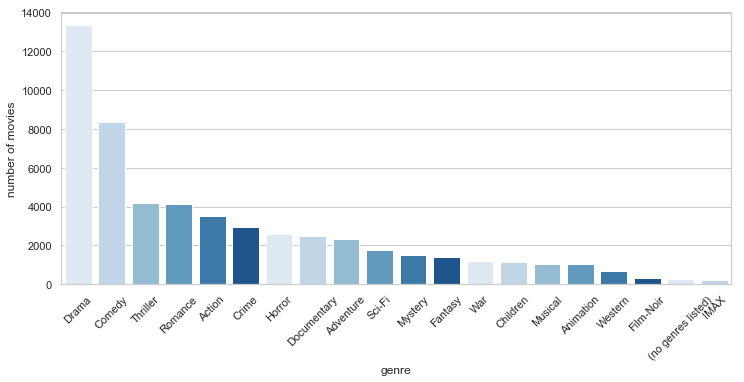

In [18]:
plt.figure(figsize=(12, 5))
sns.barplot(data=genre_count, x='genre', y='movieId', palette=sns.color_palette('Blues'))
plt.xlabel('genre')
plt.ylabel('number of movies')
plt.xticks(rotation=45);

#### Popularity of genres over time
Now that we know which are the most common genres, can we also get some information about which are the most popular ones?

We can combine the movie rating information with the movie details (like year of release) using pandas [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function, and this should yield a data frame containing all the data we need to identify popular genres over time.

In [19]:
# Perform inner join on the ratings and movies with genres data frame
genre_ratings = ratings_df.merge(movies_df_expanded, left_on='movieId', right_on='movieId', how='inner')

genre_ratings.head()



,userId,movieId,rating,timestamp,genre,title
0,1,2,3.5,2005,Adventure,Jumanji (1995)
1,1,2,3.5,2005,Children,Jumanji (1995)
2,1,2,3.5,2005,Fantasy,Jumanji (1995)
3,5,2,3.0,1996,Adventure,Jumanji (1995)
4,5,2,3.0,1996,Children,Jumanji (1995)


Before plotting this data, we can standardize the ratings so that they vary from 0 to 1 by using a technique called min-max scaling.

In [29]:
min_rating, max_rating = ratings_df.rating.min(), ratings_df.rating.max()

genre_ratings.rating = (genre_ratings.rating - min_rating) / (max_rating - min_rating)

genre_ratings.rating

0          -0.142418
1          -0.142418
2          -0.142418
3          -0.142479
4          -0.142479
5          -0.142479
6          -0.142479
7          -0.142479
8          -0.142479
9          -0.142479
10         -0.142479
11         -0.142479
12         -0.142479
13         -0.142479
14         -0.142479
15         -0.142479
16         -0.142479
17         -0.142479
18         -0.142720
19         -0.142720
20         -0.142720
21         -0.142418
22         -0.142418
23         -0.142418
24         -0.142599
25         -0.142599
26         -0.142599
27         -0.142358
28         -0.142358
29         -0.142358
              ...   
53177029   -0.142479
53177030   -0.142479
53177031   -0.142479
53177032   -0.142479
53177033   -0.142479
53177034   -0.142418
53177035   -0.142358
53177036   -0.142358
53177037   -0.142479
53177038   -0.142418
53177039   -0.142418
53177040   -0.142418
53177041   -0.142358
53177042   -0.142358
53177043   -0.142479
53177044   -0.142479
53177045   -0

By grouping the data by year and genre, we can compute the mean rating and deviation for each genre for each year.

In [28]:
# Group by multiple columns to get groups for all combinations of year and genre
rating_groups = genre_ratings.groupby(['timestamp', 'genre'])['rating']

# For each group, compute the mean and standard deviation
ratings_per_genre_per_year_summary = rating_groups.agg([np.mean, np.std]).reset_index()

ratings_per_genre_per_year_summary.head(10)

,timestamp,genre,mean,std
0,1995,Comedy,-0.141154,0.000000
1,1995,Crime,-0.141154,0.000000
2,1995,Drama,-0.140612,NaN
3,1995,Fantasy,-0.140612,NaN
4,1995,Mystery,-0.140070,NaN
5,1995,Romance,-0.140612,NaN
6,1995,Thriller,-0.140612,0.000766
7,1996,Action,-0.140917,0.000523
8,1996,Adventure,-0.140892,0.000529
9,1996,Animation,-0.140779,0.000517


One of the easiest way to see how the popularity of a genre changes over time is to create a line plot, where the y-axis shows the changes in the rating.

We will utilize IPython widget feature of jupyter notebooks to create an interactive plot that will help us see and compare genre popularity. Chose genre from the list after the cell below and use "Show confidence" to toggle confidence display. Use shift or ctrl (cmd) key to select multiple genres.

In [30]:
widget_utils.show_genre_popularity_interaction(ratings_per_genre_per_year_summary, all_genres)

#### Chose genre(s) from the list and use "Show confidence" to toggle confidence display.     Use shift or ctrl (cmd) key to select multiple genres.

interactive(children=(SelectMultiple(description='Genre:', index=(0,), options=('Adventure', 'Animation', 'Chi…

One interesting observation that can be made from the plots above is that almost all the genres were very highly rated in the year 2013.

**Optional exercise -** after finishing with this lab, can you figure out why this might be?

# Building a recommendation system

A recommendation system can be built in a number of ways - 
* Editorial and hand curated lists can be prepared by experts of the fields. For e.g. a food critic can prepare a list of best restaurants in a city.
* Simple aggregate based system can recommend the most used or the most popular items to the user.
* Personalized recommender systems that are tailored to individual users. These are the kinds of systems that are employed by companies like Amazon, Netflix etc. to recommend items/movies to users.

## Finding similar movies

In this lab, we will try to build a system that, given a query movie, suggests similar movies using the information in the dataset above. 

As we explore and develop better methods, we will take the example of the movie ***Jumanji***.

As a reminder, this is what each row in the movies data frame looks like

In [31]:
display(movies_df[movies_df.title == 'Jumanji (1995)'])
jumanji_movie_id = 2

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy


## Content based similarity
If you like movies like lord of the Rings, Harry Potter, Avengers; it is likely that in the future you'd like to watch movies like The Hobbit, The Dark Knight and other action/adventure movies. You'd not use a recommender system that suggests movies like Titanic, The Notebook etc. to you since they are not according to your taste.

A content based recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. For movie recommendation, this can work by recommending movies with same actors, director, genre(s), tag(s) etc.

### Similar movies using genres
For each movie, we can build its "profile" by identifying its key properties. For this lab, we will use the genres of movie to create the movie's profile. To do this, we will transform the genre column to create independent [dummy][1] variables for each genre. A dummy variable is a special kind of variable which is True (or 1) if that property is present and False (or 0) otherwise. For e.g. all the action movies will have 1 in the Action column whereas all the non-action movies will have a 0 in this column.

[1]:https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

In [32]:
# For each movie, separate out the genres into dummy columns
genre_dummy_cols = movies_df.genres.str.get_dummies(sep='|')

# Join it back with movies dataframe to append the dummy columns
movies_df_with_indicators = movies_df.merge(genre_dummy_cols, left_index=True, right_index=True)

movies_df_with_indicators.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Notice in the output above that the newly created dummy columns only have a 1 for those columns where the movie belongs to that particular genre.

In [33]:
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                 'Thriller', 'War', 'Western']

#### How to *measure* similarity?

Now that we have movie profile representation, we need to define a way to compute and measure the similarity between a pair of movies. It can be something as simple as "number of common genres" that the 2 movies have.

Lets write a function for this.

In [34]:
def get_similarity_genre_count(query_feats, data_feats):
    '''
    Returns similarity based on count of common items

    Parameters
    ----------
    query_feats : int
        features of the query
    data_feats : pandas datarame
        features of one or more data points

    Returns
    -------
    int, np.array
        similarity of query with each item in the data
    '''
    # Count the number of columns that have 1s for both the movies
    similar = query_feats & data_feats

    if len(similar.shape) == 1:
        return similar.sum()
    else:
        return similar.sum(axis=1)

Below is a general purpose function that takes a movie id as input, and based on the similarity function we want, returns most similar movies. The 'naive' in the name represents the fact that to compute the most similar movies, we will compare the query movie with every other movie **one at a time**.

In [35]:
def get_similar_movies_naive(movie_id, data_frame, feature_columns, sim_function, number_of_recommendations=5):
    '''
    Returns movies similar to the movie with id movie_id.
    Naive implementation of looping through each row.

    Parameters
    ----------
    movie_id : int
        query movie id
    data_frame : pandas datarame
        dataframe with information about all movies
    feature_columns: column names of features
    sim_function : function that returns similarity between query features 
                and all data points
    number_of_recommendations : int, default 5
        number of recommendations to return

    Returns
    -------
    dataframe : most similar movies
    '''
    # Get the features of the query movie
    query_row = data_frame.loc[data_frame.movieId==movie_id]
    query_genres = query_row[feature_columns].values[0]
    
    similarities = {}
    
    # Loop over all other movies
    for row_idx, row in data_frame.iterrows():
        if movie_id == row.movieId:
            continue
        
        # Compute similarity with query movie
        row_genres = row[feature_columns].values
        similar_genres = sim_function(row_genres, query_genres)
        similarities[row.movieId] = similar_genres
    
    # Sort the movies by similarity
    similarities = sorted(similarities.items(), key=operator.itemgetter(1), reverse=True)
    
    most_similar = similarities[:number_of_recommendations]
    most_similar = [info[0] for info in most_similar]
    
    # Identify the top n most similar movies
    sim_movies = data_frame[data_frame.movieId.isin(most_similar)]
        
    return sim_movies[['movieId', 'title', 'genres']]

In [36]:
%%time
display(get_similar_movies_naive(jumanji_movie_id, movies_df_with_indicators, genre_columns, get_similarity_genre_count))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
55,56,Kids of the Round Table (1995),Adventure|Children|Fantasy
59,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
124,126,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy
255,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance


Wall time: 35.6 s


%%time is an IPython [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) command that lets you measure how long did the cell take to execute.

Notice that for each movie that we want to query, this function takes ~7 seconds (on my machine) to return similar movies. On a large dataset, this will become too slow. Lets try to make this faster by [vectorizing](https://towardsdatascience.com/data-science-with-python-turn-your-conditional-loops-to-numpy-vectors-9484ff9c622e) our computation.

In [38]:
def get_similar_movies_fast(movie_id, data_frame, feature_columns, sim_function, number_of_recommendations=5):
    '''
    Returns movies similar to the movie with id movie_id.
    Vectorized implementation.

    Parameters
    ----------
    movie_id : int
        query movie id
    data_frame : pandas datarame
        dataframe with information about all movies
    feature_columns: column names of features
    sim_function : function that returns similarity between query features 
                and all data points
    number_of_recommendations : int, default 5
        number of recommendations to return

    Returns
    -------
    dataframe : most similar movies
    '''
    # Get query movie features
    query_row = data_frame.loc[data_frame.movieId==movie_id]
    query_feats = query_row[feature_columns].values

    # Get features of all other movies in a m*n array
    # where m is the number of movies and n is the number of features
    data_feats = data_frame[feature_columns].values
   
    # apply the similarity function on the 2 features sets
    similarities = sim_function(data_feats, query_feats)
    
    # Sort by similarity and return n most similar movies
    movie_id_similarity = zip(data_frame.movieId.values, similarities)
    movie_id_similarity = sorted(movie_id_similarity, key=operator.itemgetter(1), reverse=True)
    
    movie_id_similarity = pd.DataFrame(movie_id_similarity[:number_of_recommendations+1], 
                                       columns=['movieId', 'similarity'])
    
    movie_id_similarity = movie_id_similarity[movie_id_similarity.movieId!=movie_id]
    
    movie_id_similarity = movie_id_similarity.merge(data_frame, 
                                                    left_on='movieId', 
                                                    right_on='movieId')[:number_of_recommendations]
        
    return movie_id_similarity[['movieId', 'title', 'genres', 'similarity']]

In [39]:
%%time
display(get_similar_movies_fast(jumanji_movie_id, movies_df_with_indicators, genre_columns, get_similarity_genre_count))

,movieId,title,genres,similarity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3
1,56,Kids of the Round Table (1995),Adventure|Children|Fantasy,3
2,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy,3
3,126,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy,3
4,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance,3


Wall time: 62.8 ms


Whoa!! That was faster than blink of an eye!! By vectorizing our processing, we leverage the optimized low-level linear algrebra libraries to perform the matrix operations rather than using a loop. Vectorization is a very useful and common tool that is used routinely by data scientists.

Simply measuring the number of common genres is often not sufficient. For e.g. a movie that belongs to many genres will be **very** similar to almost all other movies because they'll share many common genres. We need a similarity metric that somehow normalizes this affect. 

For e.g.:

If $movie_A$ belongs to Action, Adventure;

$movie_B$ belongs to Action, Adventure, Children; and

$movie_C$ belongs to Action, Adventure, Children, Comedy, Fantasy, Sci-Fi

Our metric should return higher similarity for movies $movie_A$ and $movie_B$ than the similarity for movies $movie_A$ and $movie_C$, i.e.

$$ sim(movie_A, movie_B) > sim(movie_A, movie_C) $$

Here are a couple of other well known similarity functions that would achieve this -

[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)

[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

Below we implement a method for identifying similar movies using [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index). If A represents the genres for  $movie_A$ and B represents the genres for $movie_B$, the basic idea behind Jaccard is to compute

$$ sim_{Jaccard}(movie_A, movie_B) = \frac{A \cap B}{A \cup B} $$

That is, we want to compute the intersection of genres over the  union of genres for the 2 movies.

In [ ]:
def get_similarity_genre_jaccard(query_feats, data_feats):
    '''
    Returns similarity based using jacccard index

    Parameters
    ----------
    query_feats : int
        features of the query
    data_feats : pandas datarame
        features of all data points

    Returns
    -------
    int, np.array
        jacccard similarity of query with each item in the data
    '''
    feats_intersection = (query_feats & data_feats).sum(axis=1)
    feats_union = (query_feats | data_feats).sum(axis=1)
    
    similarities = (feats_intersection * 1.0) / feats_union
    
    return similarities

In [ ]:
%%time
display(get_similar_movies_fast(jumanji_movie_id, movies_df_with_indicators, genre_columns, get_similarity_genre_jaccard))

As can be seen from the results of the above cell, the movies returned using this function are much more similar to our query, in fact they all have **exactly the same genres** as the query.

#### But do we need to look at *all* the movies to find the most similar ones?
In a real world recommendation system, the number of options to select most similar movies from would be huge. As such, we cannot compare the query movie to each and every other movie in the dataset. In such a scenario, a common technique is to identify a subset of the options that are *approximately* very similar to the query and then compute the similarity on this reduced set. One way to accomplish this is **clustering**.

But before we do that, lets try and look at data more closely.

## Dimensionality reduction

One of the most common ways to analyze the data is to plot it to see how is it distributed across the feature space. This will not only help us determine how many clusters we need, but it will also provide insights into how the data is structured. This process is trivial when we have <= 3 features since we can visualize them in 2D or 3D, but when we have more than 3 dimensions, this becomes tricky. In these scenarios we employ a technique called **dimensionality reduction**.

Dimensionality reduction refers to the process of converting a set of data having vast dimensions into data with lesser dimensions ensuring that it conveys similar information concisely. In addition to helping with visualizations, these techniques are typically used while solving machine learning problems to obtain better features.

In this lab, we will use an algorithm called **Pricipal Component Analysis** to first reduce the dimensionality of the data to 2 so we can see them on a 2-D plot. PCA basically tries to capture and retain the directions of greatest variance in the data so that we can represent the same information in fewer dimensions.

**Optional** To learn more about PCA, refer [this](http://setosa.io/ev/principal-component-analysis/) article.

In [ ]:
# Extract just the dummy features columns
genre_data = movies_df_with_indicators[genre_columns].values

print(genre_data)
print('Shape before reduction is {}'.format(genre_data.shape))

In [ ]:
# Create a PCA model to retain just the first 2 components
pca_genre = PCA(n_components=2)
genre_xy = pca_genre.fit_transform(genre_data)
genre_x, genre_y = zip(*genre_xy)

print('Shape after reduction is {}'.format(genre_xy.shape))

Now that we have all the points projected into two dimensions, we can easily visualize them with a scatter plot.

In [ ]:
# Plot the reduced data in  2D
fig = plt.figure(figsize=(10, 5))
plt.scatter(genre_x, genre_y);

We can clearly identify subgroups of points above. By running a clustering algorithm on this data we can try to better analyze what these groups might represent.

## Clustering

<img src="https://mlvillage.blob.core.windows.net/unsupervised/clustering.png" alt="drawing" width="400" align="middle"/>

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups (clusters).

In this lab, we will use an algorithm called **K-Means**.


#### K-Means
K-Means is one of the most popular clustering algorithms. It stores k centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.

K-Means finds the best centroids by alternating between:
1. assigning data points to clusters based on the current centroids 
2. chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.<br>
<img src="https://mlvillage.blob.core.windows.net/unsupervised/kmeans-wiki.gif" alt="drawing" width="400" align="middle"/>

**Optional note -** Like most Machine Learning algorithms, K-means is also probabilistic in nature and does not necessarily provide the same solution every time.

In [ ]:
# Create k means model for 3 clusters and train it
# Note that we are clustering the points in the high dimensional space
# The 2 dimensional projection is only for visualization in our case
kmeans_genre = KMeans(n_clusters=3, random_state=0)
kmeans_genre.fit(genre_data)

Lets look at the 3 clusters, first visually and then by peeking at some samples from each cluster.

In [ ]:
# Plot the data with clusters colored differently
fig = plt.figure(figsize=(10, 5))
plt.scatter(genre_x, genre_y, c=kmeans_genre.labels_.astype(float), cmap=plt.cm.Spectral);

In [ ]:
movies_df_with_indicators.loc[:, 'cluster'] = kmeans_genre.labels_

display(movies_df_with_indicators.loc[movies_df_with_indicators.cluster==0, ['title', 'genres']].head())
display(movies_df_with_indicators.loc[movies_df_with_indicators.cluster==1, ['title', 'genres']].head())
display(movies_df_with_indicators.loc[movies_df_with_indicators.cluster==2, ['title', 'genres']].head())

Looking at the clusters, it appears that cluster 0 is composed of Action/Adventure movies, cluster 1 has comedy type movies and the last one has Drama/Romantic type movies. If you glance back at our initial plot of the distribution of movies per genre, you will find that these clusters represent the most common genres of movies.

Having this information enables us as now to make fast and efficient recommendations in three steps:
1. Look up a movie the user likes
2. find all movies in the same cluster as this movie
3. compute the similarity of the movies in the cluster to the one the user likes

In [ ]:
# find the subset of movies in same cluster as Jumanji
query_cluster = movies_df_with_indicators[movies_df_with_indicators.movieId==2]['cluster'].values[0]
reduced_movies_df_with_indicators = movies_df_with_indicators[movies_df_with_indicators.cluster == query_cluster]

In [ ]:
%%time

# compute and show similar movies
display(get_similar_movies_fast(jumanji_movie_id, reduced_movies_df_with_indicators, genre_columns, get_similarity_genre_jaccard))

Although small in magnitude, we see a speed up by doing this. In the real world, where datasets often don't even fit entirely in the memory, this method will provide a major performance boost.

Lets try to test out our recommender for some more movies. For that, we will first identify some of the most popular movies.

In [ ]:
'''
1. Get count of ratings per movie
2. Sort by most rated
3. Get 20 most rated movieIds
'''
popular_movie_ids = ratings_df.merge(movies_df, left_on='movieId', right_on='movieId')\
        .groupby('movieId')\
        .count()\
        .sort_values('rating')\
        .tail(20)\
        .index\
        .tolist()

# Get titles for popular movies
popular_movie_titles = movies_df[movies_df.movieId.isin(popular_movie_ids)]['title'].values.tolist()

popular_movie_titles

Now, run the cell below to see the recommendations for the movies we shortlisted above.

In [ ]:
methods = ['jaccard similarity of genre']

# Test out the method on multiple movies
widget_utils.show_compare_interactive(sorted(popular_movie_titles),
                                      movies_idx,
                                      movies_df,
                                      methods,
                                      movies_df_with_indicators)

### Pros of content based recommendation
* Biggest advantage of this method is that we do not need data on other users. We just need data on what the current user likes and dislikes.
* We can recommend to users that have unique tastes. For e.g. for a user who only likes French movies, we can easily identify and recommend French films.
* Because we know the profile for each film, we can recommend even unpopular and new movies.
* The recommendations provided by this method can be easily explained.


### Cons of content based recommendation
* The main drawback of our recommender is that it doesn't really allow for exploration. We will always recommend movies that are fairly similar to the ones the user liked.
* Identifying the appropriate features to create a profile is hard and needs to be continuously improved.
* For new users who do not have a profile, we cannot identify movies to suggest. This is called the cold start problem and is a general problem that all recommender systems face.

## Thank you
for completing level 1 of the unsupervised learning lab. For more advanced recommendation system models and unsupervised learning techniques, checkout level 2.

Make sure you also checkout the other labs in the Machine Learning village.

## Congratulations!

You finished this lab. If you are participating in the TS2019 Game, **please contact a volunteer to get your points!**

If you have another 45 seconds, please help us by <a href="https://www.surveymonkey.com/r/SK6XVKG" target="_blank">filling out this survey</a>.

We hope you had fun with this lab! But, wait, there is more! Come and visit the ML village website. It has access to all our lab materials so you can run the notebooks on your own machine, whenever and wherever you want. We also assembled a list of useful resources. To find our homepage you can scan the QR code below, or go to:  [https://git.corp.adobe.com/pages/TechSummit2019MLVillage/](https://git.corp.adobe.com/pages/TechSummit2019MLVillage/)

![ML Village Home Page](https://mlvillage.blob.core.windows.net/imagerecognition/ML_village_QR_code.png "ML Village Home Page")